# Swerve

Building a model off of essentially the protein features didn't produce all that much that was interesting. Lets go back and engineer some more n-gram level features and bake those into a different prediction algorithm.

In [1]:
import sqlite3
from multiprocessing import Pool
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import sklearn
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import math
import time

In [2]:
conn = sqlite3.connect("protein_training.db")
ngrams_df = pd.read_sql('SELECT * from protein_ngram',con=conn)
protein_gram_num = pd.read_sql("SELECT DISTINCT protein, COUNT(gram_num) as gram_total FROM protein_ngram GROUP BY protein", con=conn)
conn.close()
ngrams_df.drop("accession",axis=1,inplace=True)

In [3]:
# Add full n-gram sequence to ngram df
ngrams_df.loc[:,'seq'] = ngrams_df['gram_1'] + ngrams_df['gram_2'] + ngrams_df['gram_3'] + ngrams_df['gram_4'] + ngrams_df['gram_5']

In [4]:
ngrams_df.sample(5)

,protein,gram_num,gram_1,gram_2,gram_3,gram_4,gram_5,amyloid_1,amyloid_2,amyloid_3,amyloid_4,amyloid_5,seq
8026715,S27A3_HUMAN,223,A,G,P,E,F,0,0,0,0,0,AGPEF
5825644,ERG24_HUMAN,84,V,A,E,G,Q,0,0,0,0,0,VAEGQ
624754,SEPT4_HUMAN,141,K,G,F,D,F,0,0,0,0,0,KGFDF
439871,SPN1_HUMAN,199,C,Q,T,D,F,0,0,0,0,0,CQTDF
5486309,GGA2_HUMAN,149,R,D,A,Y,Q,0,0,0,0,0,RDAYQ


In [5]:
protein_gram_num.sample(5)

,protein,gram_total
4374,DCC_HUMAN,1443
8994,KPTN_HUMAN,432
3866,CRIS3_HUMAN,241
12931,PGAM4_HUMAN,250
2269,CBPA1_HUMAN,416


In [6]:
def ngramFeatureArrayizer(protein, gram_num, seq):
    """Analyze the ngram sequence as a whole"""
    feat_array = []
    prot_total_grams = protein_gram_num[protein_gram_num['protein']==protein]["gram_total"].values[0]
    gram_frac = round(gram_num / prot_total_grams, 3)
    object_ = ProteinAnalysis(seq)
    object_no_u = ProteinAnalysis(seq.replace("U","C"))
    # Mol Weight
    mol_weight = object_.molecular_weight()
    # Aromaticiy
    arom = object_.aromaticity()
    # Instability index
    try:
        insta_in = object_.instability_index()
    except:
        insta_in = object_no_u.instability_index()
    # No flexibility because the size has to be 9 amino acids at the very least
    # Gravy
    try:
        gravy_ = object_.gravy()
    except:
        gravy_ = object_no_u.gravy()
    # Isoelectric point
    try:
        iso_el = object_.isoelectric_point()
    except:
        iso_el = object_no_u.isoelectric_point()
    # Helix percentage
    sec_stru = object_.secondary_structure_fraction()
    hel_perc = sec_stru[0]
    # Turn Percentage
    turn_perc = sec_stru[1]
    # Sheet Percentage
    sheet_perc = sec_stru[2]
    # Reduced Cys Num
    mol_extinc_coeff = object_.molar_extinction_coefficient()
    red_cys = mol_extinc_coeff[0]
    # Disulfide Bridge Num
    oxi_cys = mol_extinc_coeff[1]
    feat_array.extend([
        gram_frac, mol_weight, arom, insta_in, gravy_, iso_el, hel_perc, 
        sheet_perc, turn_perc, red_cys, oxi_cys]
    )
    return feat_array

In [7]:
ngram_feat_cols = [
    "gram_frac","gram_mol_weight","gram_arom","gram_insta",
    "gram_gravy","gram_isoel","gram_helix_perc","gram_turn_perc","gram_sheet_perc",
    "gram_reduced_cys_num","gram_disulfide_num"]

In [10]:
# Find which chunk_size is the fastest
measured_times = []
for test_chunk in tqdm_notebook([100, 500, 1000, 1500, 2000, 4000, 8000, 10000, 15000, 20000]):
    start_time = time.time()
    
    start = 0
    end = test_chunk
    
    ngram_slice = ngrams_df.loc[start:end,:]
    
    ngram_slice_vals = ngram_slice.apply(
        lambda row: ngramFeatureArrayizer(
            row['protein'],
            row['gram_num'],
            row['seq'], 
        ), axis=1).values.tolist()
    
    ngram_slice_df = pd.DataFrame(ngram_slice_vals, index=range(start,end+1), columns=ngram_feat_cols)
    
    ngram_feat_full_df = pd.concat(
        [ngram_slice[["protein","gram_num"]], ngram_slice_df],
        axis=1
    )
    
    spent_time = time.time() - start_time
    
    measured_times.append([test_chunk, spent_time])

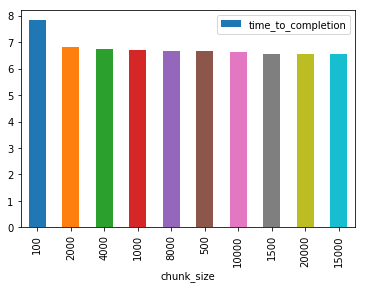

In [11]:
time_df = pd.DataFrame(measured_times, columns=['chunk_size','time_spent'])
time_df.loc[:,'iterations_needed'] = ngrams_df.shape[0] / time_df['chunk_size']
time_df.loc[:,'time_to_completion'] = (time_df['iterations_needed'] * time_df['time_spent']) / 60 / 60
time_df.sort_values('time_to_completion',inplace=True, ascending=False)
time_df.plot(kind='bar', x="chunk_size", y="time_to_completion")

In [8]:
# Lets chunk this
chunk_size = 10000
chunk_list = list(range(0, ngrams_df.shape[0],chunk_size))
chunk_pairs = [[chunk_list[i-1], chunk_list[i]] for i, x in enumerate(chunk_list) if i != 0]
chunk_pairs.append([chunk_pairs[-1][-1], None])
print(chunk_pairs[:5],"...",chunk_pairs[-5:])

[[0, 10000], [10000, 20000], [20000, 30000], [30000, 40000], [40000, 50000]] ... [[11270000, 11280000], [11280000, 11290000], [11290000, 11300000], [11300000, 11310000], [11310000, None]]


In [9]:
# sanity check chunks
chunk_0_check = ngrams_df.iloc[chunk_pairs[0][0]:chunk_pairs[0][1],:].shape[0]
chunk_1_check = ngrams_df.iloc[chunk_pairs[-1][0]:,:]

print(ngrams_df.index.values[-1]==chunk_1_check.index.values[-1])
chunk_0_check > chunk_1_check.shape[0]

True


True

In [10]:
conn = sqlite3.connect("protein_training.db")

c = conn.cursor()

tables = [x[1] for x in c.execute("SELECT * from sqlite_master WHERE type='table';")]
print(tables)

if 'protein_ngram_features_mult' not in tables:
    c.execute(
        "CREATE TABLE protein_ngram_features_mult \
            (protein text, gram_num int, gram_frac int, gram_mol_weight int, gram_arom int, gram_insta int, \
            gram_gravy int, gram_isoel int, gram_helix_perc int, gram_turn_perc int, gram_sheet_perc int, \
            gram_reduced_cys_num int, gram_disulfide_num int)"
        )

conn.close()

['protein_keywords', 'protein_ngram', 'protein_subloc', 'protein_tissue_exp_keywords', 'train', 'amyloid', 'train_scaled', 'protein_seq_features', 'train_final', 'protein_ngram_features', 'protein_ngram_features_mult']


In [ ]:
conn = sqlite3.connect("protein_training.db")

def get_ngram_feats(chunk_pair):
    start = chunk_pair[0]
    end = shunk_pair[1]
    
    if end != None:
        ngram_slice = ngrams_df.iloc[start:end, :]
    else:
        ngram_slice = ngrams_df.iloc[start:, :]
        
    slice_len = ngram_slice.shape[0]
        
    ngram_slice_vals = ngram_slice.apply(
        lambda row: ngramFeatureArrayizer(
            row['protein'],
            row['gram_num'],
            row['seq'], 
        ), axis=1).values.tolist()
    
    ngram_slice_df = pd.DataFrame(ngram_slice_vals, index=ngram_slice.index, columns=ngram_feat_cols)
    
    ngram_feat_full_df = pd.concat(
        [ngram_slice[["protein","gram_num"]], ngram_slice_df],
        axis=1
    )
    
    return ngram_feat_full_df

def write_to_dbase(chunk_pair):
    feat_df = get_ngram_feats(chunk_pair)
    feat_df.to_sql("protein_ngram_features_mult", index=False, con=conn, if_exists="append")
    
    #input = a_tuple[1]
    #output = input + 1
    #c.execute('INSERT INTO table_1 (id, output)' 'VALUES (?,?)', (index,output))

if __name__ == "__main__":
    chunks_to_run = chunk_pairs[:5]
    p = Pool(processes = 7)
    for _ in tqdm_notebook(p.imap_unordered(write_to_dbase, chunks_to_run), total=len(chunks_to_run)):
        pass
    p.close()
    p.join()

In [ ]:
conn = sqlite3.connect("protein_training.db")

for chunk in tqdm_notebook(chunk_pairs):
    
    start = chunk[0]
    end = chunk[1]
    
    if end != None:
        ngram_slice = ngrams_df.iloc[start:end, :]
    else:
        ngram_slice = ngrams_df.iloc[start:, :]
        
    slice_len = ngram_slice.shape[0]
        
    ngram_slice_vals = ngram_slice.apply(
        lambda row: ngramFeatureArrayizer(
            row['protein'],
            row['gram_num'],
            row['seq'], 
        ), axis=1).values.tolist()
    
    ngram_slice_df = pd.DataFrame(ngram_slice_vals, index=ngram_slice.index, columns=ngram_feat_cols)
    
    ngram_feat_full_df = pd.concat(
        [ngram_slice[["protein","gram_num"]], ngram_slice_df],
        axis=1
    )
        
    ngram_feat_full_df.to_sql('protein_ngram_features', con=conn, index=False, if_exists='append')
            
conn.close()

Now that we've got the ngram sequence analyzed and recorded as a whole, lets look into the amino acids and put some features in based around those.

In [13]:
conn.close()

In [22]:
range(start, end-1)

range(11310000, 11319554)

In [23]:
# Sanity check
conn = sqlite3.connect("protein_training.db")

c = conn.cursor()

ngram_n = [x[0] for x in c.execute("SELECT COUNT(*) FROM protein_ngram")][0]
ngram_feat_n = [x[0] for x in c.execute("SELECT COUNT(*) FROM protein_ngram_features")][0]

conn.close()

ngram_n == ngram_feat_n

False

In [30]:
ngram_n, ngram_feat_n

(11319554, 11320685)

In [36]:
ngram_feat_n - ngram_n

1131

In [84]:
# Get protein and gram nums for each
# Sanity check
conn = sqlite3.connect("protein_training.db")

ngram_feats = pd.read_sql("SELECT * FROM protein_ngram_features", con=conn)

conn.close()

In [ ]:
11310000